In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Load the Data

In [2]:
train_data = pd.read_csv('../input/titanic/train.csv')
test_data = pd.read_csv('../input/titanic/test.csv')

# Take a Quick Look at the Data Structure


In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Information About Data


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Values Of Our Categorical Variable

In [5]:
#train_data["Name"].value_counts()
#train_data["Sex"].value_counts()
#train_data["Ticket"].value_counts()
train_data["Cabin"].value_counts()
#train_data["Embarked"].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [6]:
train_data["new_Cabin"] = train_data["Cabin"].astype(str).str[0]
train_data["new_Cabin"].value_counts()
test_data["new_Cabin"] = test_data["Cabin"].astype(str).str[0]


# Let's take a look at the numerical attributes

In [7]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
new_Cabin        0
dtype: int64

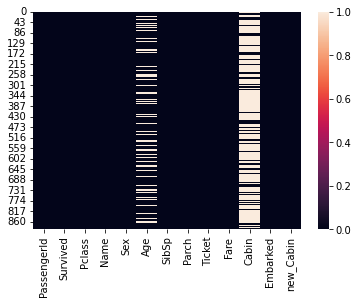

In [8]:
sns.heatmap(train_data.isnull())
train_data.isnull().sum()

<AxesSubplot:>

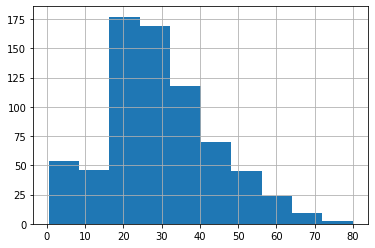

In [9]:
train_data["Age"].hist()

In [10]:
train_data["Agecat"] = train_data["Age"] // 15 * 15
train_data[["Agecat", "Survived"]].groupby(['Agecat']).mean()
test_data["Agecat"] = test_data["Age"] // 15 * 15


# Looking for Correlations

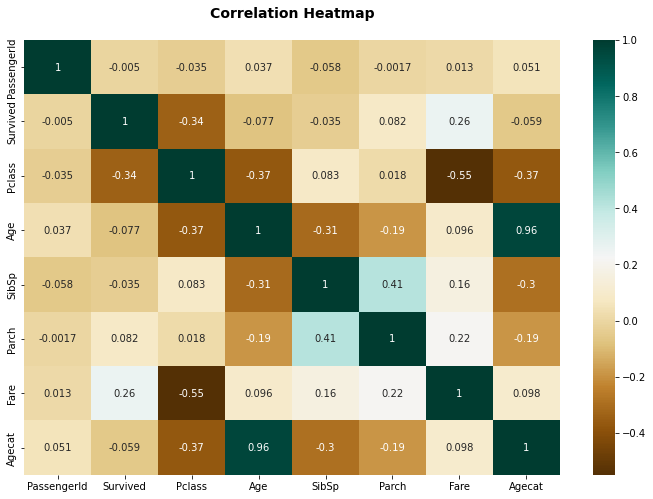

In [11]:
plt.figure(figsize=(12,8))
sns.heatmap(train_data.corr(),annot=True,cmap='BrBG')
plt.title('Correlation Heatmap\n',fontweight='bold',fontsize=14)
plt.show()


In [12]:
corr_matrix = train_data.corr()
corr_matrix["Survived"].sort_values(ascending=False)


Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Agecat        -0.058848
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

# Pipeline for Numerical Attributes

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

# Pipeline for Categorical Attributes

In [14]:
from sklearn.preprocessing import OneHotEncoder
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

# PIPELINE

In [15]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare","Agecat"]
cat_attribs = ["Pclass", "Sex", "Embarked", "new_Cabin"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [16]:
X_train = preprocess_pipeline.fit_transform(
    train_data[num_attribs + cat_attribs])
X_train
X_train.shape

(891, 22)

In [17]:
y_train = train_data["Survived"]

# Select and Train a Model

# Training and Evaluating on the Training Set


In [18]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [19]:
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred = forest_clf.predict(X_test)

In [20]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

In [21]:
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred2 = svm_clf.predict(X_test)

result = pd.DataFrame({'PassengerId':test_data['PassengerId'],'Survived':y_pred2})
result


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [22]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [23]:
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred3 = sgd_clf.predict(X_test)

# Performance Measures


# Cross Validation

In [24]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()


0.8260549313358301

In [25]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8115106117353308

In [26]:
sgd_scores = cross_val_score(sgd_clf, X_train, y_train, cv=10)
sgd_scores.mean()

0.7711360799001248

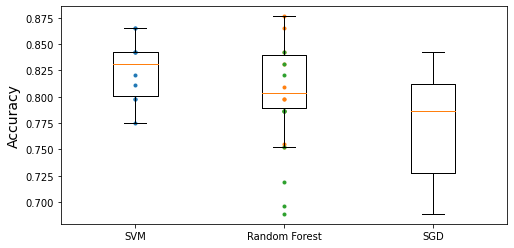

In [27]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores,".")
plt.plot([2]*10, forest_scores, ".")
plt.plot([2]*10, sgd_scores, ".")
plt.boxplot([svm_scores, forest_scores, sgd_scores], labels=("SVM","Random Forest","SGD"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

# Confusion Matrix


In [28]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(svm_clf, X_train, y_train, cv=3)

In [29]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred)

array([[487,  62],
       [ 95, 247]])

In [30]:
y_train_perfect_predictions = y_train  # pretend we reached perfection
confusion_matrix(y_train, y_train_perfect_predictions)

array([[549,   0],
       [  0, 342]])

# Precision and Recall

In [31]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train, y_train_pred)

0.7993527508090615

In [32]:
recall_score(y_train, y_train_pred)

0.7222222222222222

# F1 Score

In [33]:
from sklearn.metrics import f1_score

f1_score(y_train, y_train_pred)

0.7588325652841783

# Precision/Recall Trade-off


In [34]:
y_scores = cross_val_predict(svm_clf, X_train, y_train, cv=3,
                             method="decision_function")

In [35]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

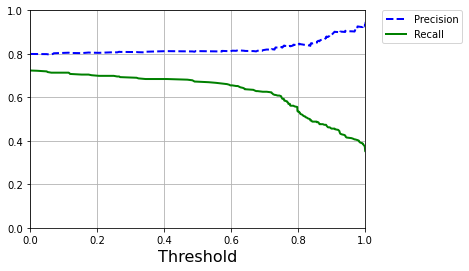

<Figure size 576x288 with 0 Axes>

In [36]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)  
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.axis([0, 1, 0, 1])
    plt.figure(figsize=(8, 4))                                                                
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

# The ROC Curve


In [37]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

In [38]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, y_scores)

0.8464592720416706

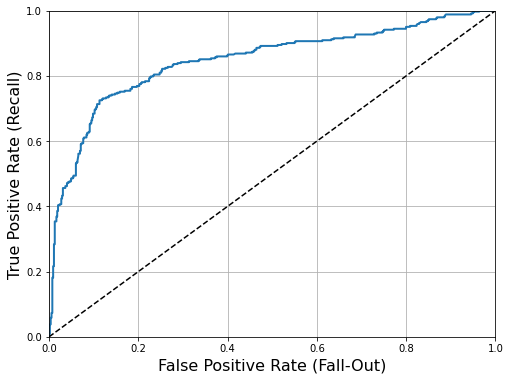

In [39]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1]) 
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6)) 
plot_roc_curve(fpr, tpr)
plt.show()

# Fine-Tune Your Model

# Grid Search


In [40]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_train, y_train)



Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.687, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.646, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.640, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.646, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.629, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.821, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.798, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.798, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.815, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.626, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.669, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.635, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.646, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    5.0s finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [41]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=100, gamma=0.01)


# Evaluate Your System on the Test Set


In [42]:
final_model = grid.best_estimator_
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
final_predictions = final_model.predict(X_test)

fm_scores = cross_val_score(final_model, X_train, y_train, cv=10)
fm_scores.mean()


0.8283395755305868